<a href="https://colab.research.google.com/github/mayakhesin/expiring-mab/blob/master/Piki_Simulations_1_6_TOP_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

lb = pd.read_csv('/content/gdrive/My Drive/Piki/raw_data_top_shows_2.csv')
show_date = lb['show_date']
lb.head()

def binary(cell):
  if cell == 'song_next':
    return 0
  else:
    return 1

lb['action_number'] = lb['action'].apply(binary)
lb = lb.pivot_table(values='action_number', index=['artist', 'show_date'], aggfunc = [len, sum])
lb.columns = lb.columns.get_level_values(0)
lb.rename(columns = {'len': 'cnt', 'sum': 'success_count'}, inplace=True)
lb.sort_values(by='show_date', inplace=True)
lb = lb.reset_index()
lb['failure_count'] = lb['cnt'] - lb['success_count']
probability = (lb['success_count']+1)/(lb['success_count']+lb['failure_count']+2)
lb['probability'] = probability
lb['show_date'] = pd.to_datetime(lb.show_date)
CURRENT_DATE = pd.to_datetime('2019-09-01')
lb['datediff'] = (lb['show_date'] - CURRENT_DATE).dt.days
lb

,artist,show_date,cnt,success_count,failure_count,probability,datediff
0,Hot Chip,2019-09-03,7,6,1,0.777778,2
1,Two Door Cinema Club,2019-09-13,7,5,2,0.666667,12
2,Andrew Bird,2019-09-17,2,2,0,0.750000,16
3,Cat Power,2019-09-22,1,1,0,0.666667,21
4,Bastille,2019-09-24,9,1,8,0.181818,23
5,Bombay Bicycle Club,2019-10-07,1,0,1,0.333333,36
6,Explosions in the Sky,2019-10-12,3,2,1,0.600000,41
7,Beirut,2019-12-01,3,2,1,0.600000,91


In [0]:
# based on https://gdmarmerola.github.io/ts-for-bernoulli-bandit/

class MAB:
  '''Class for a row of bandits'''
  def __init__(self, bandit_probs, days_until_show):
    self.bandit_probs = bandit_probs.copy()
    self.days_until_show = days_until_show.copy()
        
  def draw(self, k, day_number):
    ''' Function that draws from the bandits.
    Returns the reward and the regret of the action
    '''
    return (np.random.binomial(1, self.bandit_probs[k]),    # reward
            np.max(self.bandit_probs[self.days_until_show >= day_number]) - self.bandit_probs[k])  # regret
  
  def add_new_bandit(self, probability, days_until_show):
    self.bandit_probs[len(self.bandit_probs)] = probability
    self.days_until_show[len(self.days_until_show)] = days_until_show
    
  def get_num_bandits(self):
    return len(self.bandit_probs)

class eGreedyPolicy:
  def __init__(self, epsilon):
    self.epsilon = epsilon

  def name(self):
    return 'ε-Greedy (ε = ' + str(self.epsilon) + ')'
        
  def choose_bandit(self, k_array, reward_array, n_bandits, frozen, discount, days_until_show):
    success_count = reward_array.sum(axis=1) + 1
    total_count = k_array.sum(axis=1) + 2
    success_ratio = success_count/total_count
    if discount:
      success_ratio *= DISCOUNT_FACTOR**days_until_show
    if not frozen:
      success_ratio[days_until_show < 0] = -1  
    # choosing best greedy action or random depending with epsilon probability
    best = np.argmax(success_ratio)
    if np.random.random() < self.epsilon:
      # returning random action, excluding best and expired
      mask = np.ones(n_bandits, bool)
      mask[best] = False
      mask[days_until_show < 0] = False
      arr = np.arange(n_bandits)[mask]
      # arr = np.delete(np.arange(n_bandits), np.where(mask))
      if len(arr) == 0:
        # nothing left to probe, just keep using the best
        return best
      return np.random.choice(arr)
    else:
      # returning best greedy action
      return best

class UCBPolicy:
  def __init__(self):
    pass

  def name(self):
    return 'UCB'
    
  def choose_bandit(self, k_array, reward_array, n_bandits, frozen, discount, days_until_show):
    # sucesses and total draws
    success_count = reward_array.sum(axis=1) + 1
    total_count = k_array.sum(axis=1) + 2
    sum_total_count = np.sum(total_count)
    # if sum_total_count == 0:
    #  return 0
    success_ratio = success_count/total_count
    # computing confidence interval
    sqrt_term = np.full(len(total_count), np.inf)
    sqrt_term[total_count != -1] = np.sqrt(2*np.log(sum_total_count)/total_count[total_count != -1])
    # returning best greedy action
    candidates_list = success_ratio + sqrt_term
    if discount:
      candidates_list *= DISCOUNT_FACTOR**days_until_show
    if not frozen:
      candidates_list[days_until_show < 0] = -1
    return np.argmax(candidates_list)

class TSPolicy:
  def __init__(self):
    pass

  def name(self):
    return 'Thompson Sampling'
      
  def choose_bandit(self, k_array, reward_array, n_bandits, frozen, discount, days_until_show):
    success_count = reward_array.sum(axis=1)
    failure_count = k_array.sum(axis=1) - success_count
    # drawing a sample from each bandit distribution
    samples_list = np.array([np.random.beta(1 + success_count[bandit_id], 1 + failure_count[bandit_id]) for bandit_id in range(n_bandits)])
    
    # discounting the reward
    if discount:
      samples_list *= DISCOUNT_FACTOR**days_until_show
    # set samples for expired bandits to -1 so that they will not get picked
    if not frozen:
      samples_list[days_until_show < 0] = -1
    # returning bandit with best sample
    return np.argmax(samples_list)
  
def choose_probability(mean, stdv):
  while True:
    prob = np.random.normal(mean, stdv)
    if prob >= 0 and prob <= 1:
      return prob

def simulate(policy, frozen, discount, new_shows):
  mab = MAB(lb['probability'], lb['datediff'])
  # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
  k_array = np.zeros((mab.get_num_bandits(),N_DRAWS))
  reward_array = np.zeros((mab.get_num_bandits(),N_DRAWS))
  regret_array = np.zeros((mab.get_num_bandits(),N_DRAWS))
  # lists for ease of use, visualization
  k_list = []
  reward_list = []
  regret_list = []
  num_new_bandits = 0
  # loop generating draws
  for draw_number in range(N_DRAWS):
    day_number = 0 if frozen else draw_number // N_DRAWS_PER_DAY
    days_until_show = mab.days_until_show.to_numpy()
    if not frozen:
      # don't use -= to avoid modifying mab 
      days_until_show = days_until_show - day_number
    k = policy.choose_bandit(k_array, reward_array, mab.get_num_bandits(), frozen, discount, days_until_show)
    reward, regret = mab.draw(k, day_number)
    if discount: #discount:
      reward = reward*DISCOUNT_FACTOR**days_until_show[k]
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
    regret_array[k, draw_number] = regret
    if new_shows:
      if draw_number%N_DRAWS_PER_DAY == 0:
        for i in range(NUM_NEW_SHOWS_PER_DAY):
          mab.add_new_bandit(PROBABILITIES_LIST[num_new_bandits], day_number + EXPIRATION_DATES[num_new_bandits])
          num_new_bandits += 1
        reward_array = np.vstack([reward_array, np.zeros((NUM_NEW_SHOWS_PER_DAY, N_DRAWS))])
        regret_array = np.vstack([regret_array, np.zeros((NUM_NEW_SHOWS_PER_DAY, N_DRAWS))])
        k_array = np.vstack([k_array, np.zeros((NUM_NEW_SHOWS_PER_DAY, N_DRAWS))])
  return reward_array, regret_array, k_list, mab

def plot(policy, frozen, discount, new_shows):
  reward_array, regret_array, k_list, mab = simulate(policy, frozen, discount, new_shows)
  
  fig, ax = plt.subplots(1, 5)
  fig.set_size_inches(17, 2)

  reward_df = pd.DataFrame(reward_array)
  reward_cumulative = reward_df.cumsum(axis=1).sum(axis=0)
  # reward_cumulative.plot(kind='line', ax=ax[0])
  reward_df.sum(axis=0).plot(style='.', markersize=1, ax=ax[0])
  ax[0].set_xlabel("draw #")  
  ax[0].set_ylabel("tickets purchased")

  exp = mab.days_until_show[k_list]
  pd.Series(np.array(exp)).plot(style='.', markersize=1, ax=ax[1])
  ax[1].set_xlabel("draw #")  
  ax[1].set_ylabel("expiration day\nfor picked song")
    
  k_list_df = pd.DataFrame(k_list)
  k_list_df.plot(style='.', markersize=1, ax=ax[2])
  ax[2].set_xlabel("draw #")  
  ax[2].set_ylabel("show # picked")
  # no idea why it gets displayed here but not in others
  ax[2].get_legend().remove()

  def plot_series_transposed(series, ax):
    ax.plot(series.to_numpy(), series.index.values, 'o', markersize=1)
    
  plot_series_transposed(mab.bandit_probs, ax[3])
  ax[3].set_xlabel("probability")
  ax[3].set_ylabel("show #")
  plot_series_transposed(mab.days_until_show * N_DRAWS_PER_DAY, ax[4])
  ax[4].set_xlabel("expiration, draws")
  ax[4].set_ylabel("show #")

  for a in ax[2:]:
    a.set_ylim(0, mab.get_num_bandits())
    
  plt.tight_layout()
  plt.show()
  return reward_cumulative

# number of draws
N_DRAWS_PER_DAY = 40
N_DAYS = 45
N_DRAWS = N_DRAWS_PER_DAY * N_DAYS
DISCOUNT_FACTOR = .995
NUM_DAYS_UNTIL_SHOW = (10, 60) # uniformly distributed
NUM_NEW_SHOWS_PER_DAY = 3
MEAN = .625
STDV = .15

PROBABILITIES_LIST = []
EXPIRATION_DATES = []
for i in range(N_DRAWS//N_DRAWS_PER_DAY*NUM_NEW_SHOWS_PER_DAY):
  PROBABILITIES_LIST.append(choose_probability(MEAN, STDV))
  EXPIRATION_DATES.append(np.random.randint(NUM_DAYS_UNTIL_SHOW[0], NUM_DAYS_UNTIL_SHOW[1]))

Simulation with time frozen and no discount, no new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t)))$, where

$a_t$ = the action taken at time *t*

$R_t(a_t)$ = the reward of the action $a_t$.

Note: Time is measured in draws.

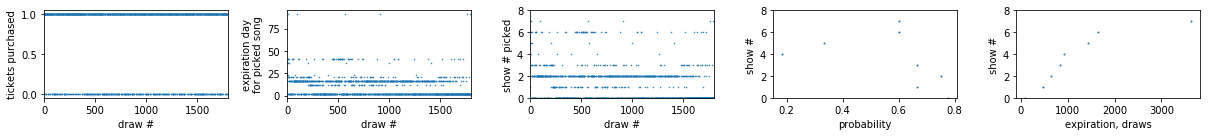

In [4]:
reward_cumulative_frozen_nodiscount_nonewshows = plot(TSPolicy(), True, False, False)

Simulation with time flow but no discount, no new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t)))$ , where

$𝑎_𝑡$  = the action taken at time t, choosing from the shows that have not expired **(Is there a way to put this in mathematical terms?)**

$𝑅_𝑡(𝑎_𝑡)$  = the reward of the action $a_t$

Note: Time is measured in draws.

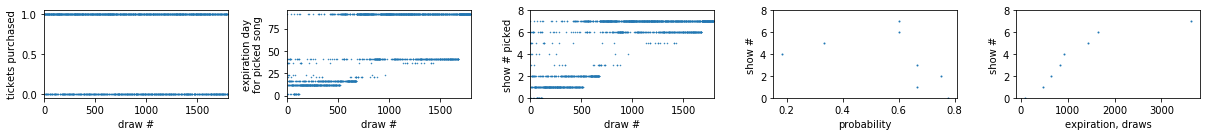

In [5]:
reward_cumulative_notfrozen_nodiscount_nonewshows = plot(TSPolicy(), False, False, False)

Simulation with time frozen and discount, no new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t) \times d^{U(a_t)}))$ , where

$𝑎_𝑡$  = the action taken at time $t$

$𝑅_𝑡(𝑎_𝑡)$  = the reward of the action $a_t$

$𝑑$  = the discount factor

$𝑈(𝑎_t)$ = the number of days until the show $a_t$

$p$ = number of draws per day

Note: Time is measured in draws.

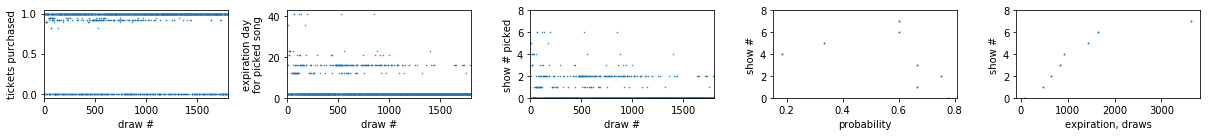

In [6]:
reward_cumulative_frozen_discount_nonewshows = plot(TSPolicy(), True, True, False)

Simulation with time frozen and discount, no new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t) \times d^{U(a_t)}))$ , where

$𝑎_𝑡$  = the action taken at time $t$

$𝑅_𝑡(𝑎_𝑡)$  = the reward of the action $a_t$

$𝑑$  = the discount factor

$𝑈(𝑎_t)$ = the number of days until the show $a_t$

$p$ = number of draws per day

Note: Time is measured in draws.

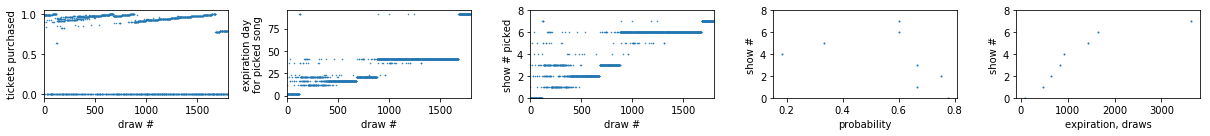

In [7]:
reward_cumulative_notfrozen_discount_nonewshows = plot(TSPolicy(), False, True, False)

Plot of all four cumulative rewards (with no new shows)

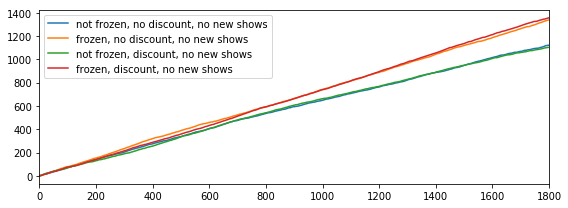

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 3)
reward_cumulative_notfrozen_nodiscount_nonewshows.plot(kind='line', label='not frozen, no discount, no new shows', ax=ax)
reward_cumulative_frozen_nodiscount_nonewshows.plot(kind='line', label='frozen, no discount, no new shows', ax=ax)
reward_cumulative_notfrozen_discount_nonewshows.plot(kind='line', label='not frozen, discount, no new shows', ax=ax)
reward_cumulative_frozen_discount_nonewshows.plot(kind='line', label='frozen, discount, no new shows', ax=ax)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

Simulation with no discount and time not frozen, new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t)))$, where

$a_t$ = the action taken at time *t*, choosing from the shows that have not expired **(Is there a way to put this in mathematical terms?)**

$R_t(a_t)$ = the reward of the action $a_t$.

Note: Time is measured in draws. **Not sure how to mathematically state that new shows are being added.**

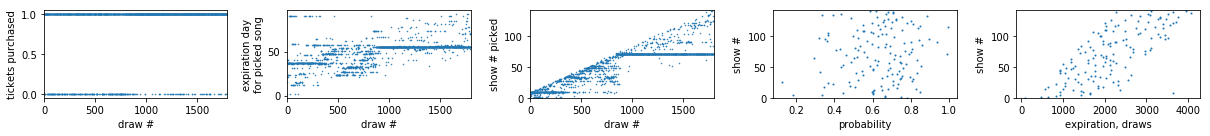

In [9]:
reward_cumulative_notfrozen_nodiscount_newshows = plot(TSPolicy(), False, False, True)

Simulation with discount and time not frozen, new shows added

Objective: $\underset{a \in A}\max(\mathbb E(\sum_{t=0}^{T} R_t(a_t) \times d^{U(a_t)- \lfloor t/p \rfloor}))$ , where

$𝑎_𝑡$  = the action taken at time t, choosing from the shows that have not expired **(Is there a way to put this in mathematical terms?)**

$𝑅_𝑡(𝑎_𝑡)$  = the reward of the action $a_t$

$𝑑$  = the discount factor

$𝑈(𝑎_t)$ = the number of days until the show $a_t$

$p$ = number of draws per day

Note: Time is measured in draws. **Not sure how to mathematically state that new shows are being added.**

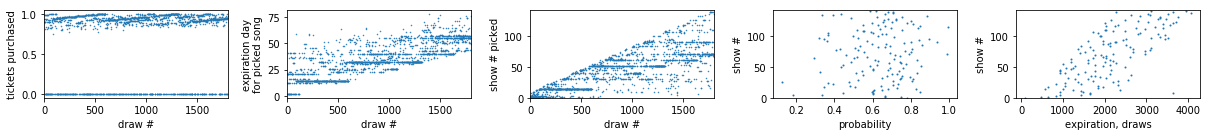

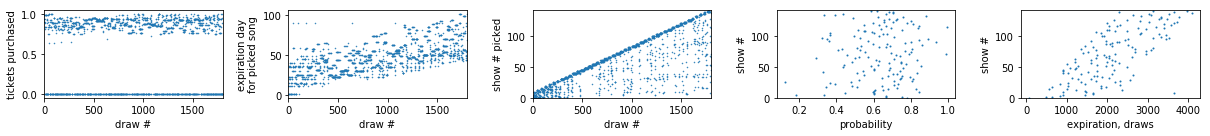

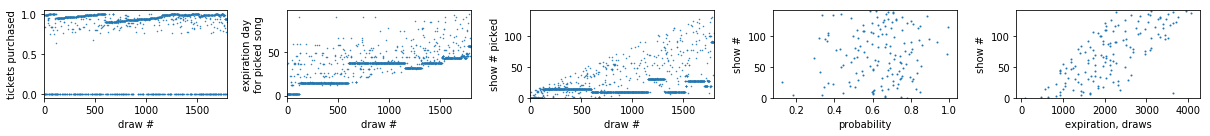

In [10]:
reward_cumulative_notfrozen_discount_newshows = plot(TSPolicy(), False, True, True)
reward_cumulative_notfrozen_discount_newshows = plot(UCBPolicy(), False, True, True)
reward_cumulative_notfrozen_discount_newshows = plot(eGreedyPolicy(.2), False, True, True)

Plot of both cumulative rewards (with new shows)

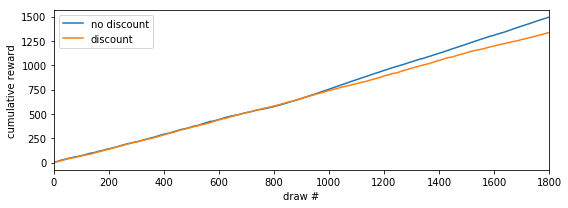

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 3)
# reward_cumulative_notfrozen_nodiscount_newshows.plot(kind='line', label='not frozen, no discount, new shows', ax=ax)
# reward_cumulative_notfrozen_discount_newshows.plot(kind='line', label='not frozen, discount, new shows', ax=ax)
reward_cumulative_notfrozen_nodiscount_newshows.plot(kind='line', label='no discount', ax=ax)
reward_cumulative_notfrozen_discount_newshows.plot(kind='line', label='discount', ax=ax)
ax.set_xlabel("draw #")
ax.set_ylabel("cumulative reward")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [0]:
def plot_policies(frozen, new_shows):
  discount = True
  fig, ax = plt.subplots(1, 2)
  fig.set_size_inches(12, 3)
  fig1, ax1 = plt.subplots(1, 3)
  fig1.set_size_inches(12, 2)
  f_label = 'Frozen' if frozen else 'Not frozen'
  n_label = 'new shows' if new_shows else 'no new shows'
  fig.suptitle(f_label + ', ' + n_label)

  def make_cumulative_plot(array, ax):
    df = pd.DataFrame(array)
    cumulative = df.cumsum(axis=1).sum(axis=0)
    cumulative.plot(kind='line', label=policy.name(), ax=ax)
  
  policies = (TSPolicy(), UCBPolicy(), eGreedyPolicy(0.2))
  for i in range(len(policies)):
    policy = policies[i]
    reward_array, regret_array, k_list, mab = simulate(policy, frozen, discount, new_shows)
    make_cumulative_plot(reward_array, ax[0])
    make_cumulative_plot(regret_array, ax[1])

    k_list_df = pd.DataFrame(k_list)
    k_list_df.plot(style='.', markersize=1, ax=ax1[i])
    ax1[i].set_xlabel("draw #")  
    ax1[i].set_ylabel("show # picked")
    # no idea why it gets displayed here but not in others
    ax1[i].get_legend().remove()  
    ax1[i].set_title(policy.name())

  for a in ax: 
    a.legend(loc='best')
    a.set_xlabel('draw number')
  ax[0].set_ylabel('cumulative reward')
  ax[1].set_ylabel('cumulative regret')
  fig1.show()
  fig.show()

plot_policies(True, False)
plot_policies(False, False)
plot_policies(False, True)

In [0]:
reward_cumulative_notfrozen_nodiscount_nonewshows.plot(kind='line', label='not frozen, no discount, no new shows', ax=ax)
reward_cumulative_frozen_nodiscount_nonewshows.plot(kind='line', label='frozen, no discount, no new shows', ax=ax)
reward_cumulative_notfrozen_discount_nonewshows.plot(kind='line', label='not frozen, discount, no new shows', ax=ax)